In [1]:
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from torchsummary import summary
import time
from tqdm.notebook import tqdm_notebook
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.10.0+cu111
Torchvision Version:  0.11.1+cu111


In [12]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "drive/MyDrive/images"

# Number of classes in the dataset
num_classes = 58

# Batch size for training (change depending on how much memory you have)
batch_size = 8

# Number of epochs to train for 
num_epochs = 5

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

In [13]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    train_loss_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    print("Traning")
    for epoch in tqdm_notebook(range(num_epochs)):
        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
  
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, train_loss_history

In [14]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [15]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    print(model_name)
    if model_name == "inception":
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299
    elif model_name == "resnet":
        
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
    elif model_name == "mobilenet_v2":
        
        model_ft = models.mobilenet_v2(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = torch.nn.Linear(in_features=model_ft.classifier[1].in_features,
                                                 out_features=num_classes)
        input_size = 224
    elif model_name == "regnet_x_32gf":
        
        model_ft = models.regnet_x_32gf(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224
            

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size


In [16]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

def data_transform(input_size):
    # Data augmentation and normalization for training
    # Just normalization for validation
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(input_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'test': transforms.Compose([
            transforms.Resize(input_size),
            transforms.CenterCrop(input_size),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }


    test_data = torchvision.datasets.ImageFolder(data_dir + '/val',transform=data_transforms['test'])
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=4)

    print("Initializing Datasets and Dataloaders...")

    # Create training and validation datasets
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
    # Create training and validation dataloaders
    dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

    return dataloaders_dict,test_loader

In [18]:
# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Initialize the model for this run
model_inception, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
trainloaders_dict,test_loader = data_transform(input_size)
# Send the model to GPU

model_inception = model_inception.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_inception.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_inception.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_inception.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

inception


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Initializing Datasets and Dataloaders...
Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [19]:
# Print the model we just instantiated
summary(model_inception, (3, 299, 299))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

In [21]:
# Train and evaluate
model_inception, hist, train_acc_history, train_loss_history = train_model(model_inception, 
                                                                    trainloaders_dict, 
                                                                    criterion, optimizer_ft, 
                                                                    num_epochs=num_epochs, 
                                                                    is_inception=(model_name=="inception"))

Traning


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training complete in 9m 18s
Best val Acc: 0.603131


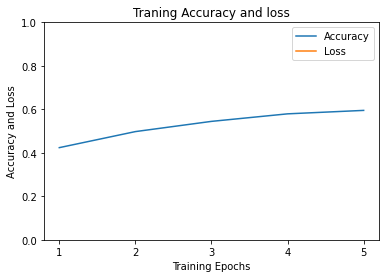

In [22]:
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in train_acc_history]
shist = [h for h in train_loss_history]

plt.title("Traning Accuracy and loss")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy and Loss")
plt.plot(range(1,num_epochs+1),ohist,label="Accuracy")
plt.plot(range(1,num_epochs+1),shist,label="Loss")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [24]:
img_test_transforms = transforms.Compose([
    transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_data = torchvision.datasets.ImageFolder(data_dir + '/val',transform=img_test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          shuffle=False, num_workers=4)
# test-the-model
model_inception.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
       
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_inception(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        print("input",labels)
        print("output",predicted)
        
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))
    print('correct: {:d}  total: {:d}'.format(correct, total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


input tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
output tensor([ 0,  0,  0,  0,  0,  0,  0, 34], device='cuda:0')
input tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
output tensor([0, 0, 6, 0, 4, 0, 0, 0], device='cuda:0')
input tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
output tensor([ 0,  0,  0,  0,  0, 34, 34, 34], device='cuda:0')
input tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
output tensor([23, 23, 34, 23, 55, 34,  0, 23], device='cuda:0')
input tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
output tensor([ 0,  4, 50, 34,  0, 34, 34, 34], device='cuda:0')
input tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
output tensor([2, 2, 6, 2, 2, 2, 2, 2], device='cuda:0')
input tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
output tensor([ 2, 55,  2,  2,  2,  2,  6,  2], device='cuda:0')
input tensor([2, 2, 2, 2, 2, 2, 3, 3], device='cuda:0')
output tensor([ 6, 55,  6,  2,  2,  2,  3,  3], device='cuda:0')
input tensor([3, 3, 3, 3, 3, 3, 3, 3], device='c

In [25]:
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_inception(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
torch.save(model_inception.state_dict(), "inception.pth")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[18.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 3.,  0.,  0.,  ...,  1.,  0.,  0.],
        [ 0.,  0., 16.,  ...,  2.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 36.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])


In [26]:
model_name = "resnet"
# Initialize the model for this run
model_resnet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
trainloaders_dict,test_loader = data_transform(input_size)
# Send the model to GPU
model_resnet = model_resnet.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_resnet.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_resnet.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_resnet.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

resnet


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Initializing Datasets and Dataloaders...
Params to learn:
	 fc.weight
	 fc.bias


In [27]:
summary(model_resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [30]:
# Train and evaluate
model_resnet, hist, train_acc_history, train_loss_history = train_model(model_resnet,
                                                                    trainloaders_dict,
                                                                    criterion,
                                                                    optimizer_ft,
                                                                    num_epochs=num_epochs,
                                                                    is_inception=(model_name=="inception"))

Traning


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training complete in 2m 56s
Best val Acc: 0.750170


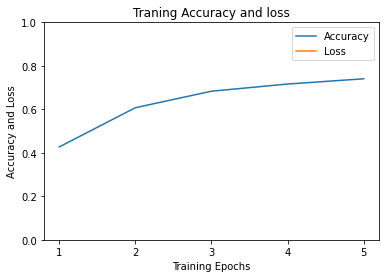

In [37]:
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in train_acc_history]
shist = [h for h in train_loss_history]

plt.title("Traning Accuracy and loss")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy and Loss")
plt.plot(range(1,num_epochs+1),ohist,label="Accuracy")
plt.plot(range(1,num_epochs+1),shist,label="Loss")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [39]:
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_resnet(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
torch.save(model_resnet.state_dict(), "resnet18.pth")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[19.,  2.,  0.,  ...,  0.,  0.,  0.],
        [ 3.,  8.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 19.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 32.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]])


In [40]:
model_name = "mobilenet_v2"
# Initialize the model for this run
model_mobilenet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
trainloaders_dict,test_loader = data_transform(input_size)
# Send the model to GPU
model_mobilenet = model_mobilenet.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_mobilenet.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_mobilenet.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_mobilenet.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

mobilenet_v2


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Initializing Datasets and Dataloaders...
Params to learn:
	 classifier.1.weight
	 classifier.1.bias


In [41]:
summary(model_mobilenet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [42]:
# Train and evaluate
model_mobilenet, hist, train_acc_history, train_loss_history = train_model(model_mobilenet,
                                                                    trainloaders_dict,
                                                                    criterion,
                                                                    optimizer_ft,
                                                                    num_epochs=num_epochs,
                                                                    is_inception=(model_name=="mobilenet"))

Traning


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training complete in 3m 6s
Best val Acc: 0.737917


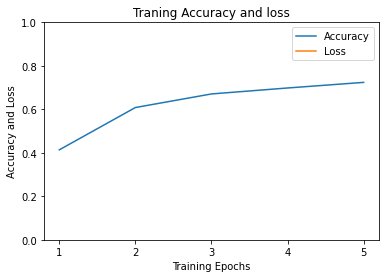

In [44]:
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in train_acc_history]
shist = [h for h in train_loss_history]

plt.title("Traning Accuracy and loss")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy and Loss")
plt.plot(range(1,num_epochs+1),ohist,label="Accuracy")
plt.plot(range(1,num_epochs+1),shist,label="Loss")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [45]:
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_mobilenet(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
torch.save(model_mobilenet.state_dict(), "mobilenet.pth")

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


tensor([[23.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 2.,  7.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0., 20.,  ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0.,  ..., 35.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  ...,  2.,  0.,  0.]])


In [46]:
model_name = "regnet_x_32gf"
# Initialize the model for this run
model_regnet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
trainloaders_dict,test_loader =data_transform(input_size)
# Send the model to GPU
model_regnet = model_regnet.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_regnet.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_regnet.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_regnet.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

regnet_x_32gf


Downloading: "https://download.pytorch.org/models/regnet_x_32gf-9d47f8d0.pth" to /root/.cache/torch/hub/checkpoints/regnet_x_32gf-9d47f8d0.pth


  0%|          | 0.00/412M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Initializing Datasets and Dataloaders...
Params to learn:
	 fc.weight
	 fc.bias


In [47]:

summary(model_regnet, (3, 224, 224))
#print(model_ft)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              ReLU-3         [-1, 32, 112, 112]               0
            Conv2d-4          [-1, 336, 56, 56]          10,752
       BatchNorm2d-5          [-1, 336, 56, 56]             672
            Conv2d-6        [-1, 336, 112, 112]          10,752
       BatchNorm2d-7        [-1, 336, 112, 112]             672
              ReLU-8        [-1, 336, 112, 112]               0
            Conv2d-9          [-1, 336, 56, 56]         508,032
      BatchNorm2d-10          [-1, 336, 56, 56]             672
             ReLU-11          [-1, 336, 56, 56]               0
           Conv2d-12          [-1, 336, 56, 56]         112,896
      BatchNorm2d-13          [-1, 336, 56, 56]             672
             ReLU-14          [-1, 336,

In [48]:
# Train and evaluate
model_regnet, hist, train_acc_history, train_loss_history = train_model(model_regnet,
                                                                    trainloaders_dict,
                                                                    criterion,
                                                                    optimizer_ft,
                                                                    num_epochs=num_epochs,
                                                                    is_inception=(model_name=="regnet"))

Traning


  0%|          | 0/5 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training complete in 28m 46s
Best val Acc: 0.735875


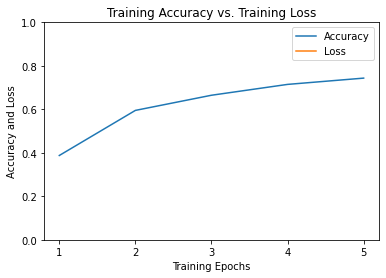

In [49]:
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in train_acc_history]
shist = [h for h in train_loss_history]

plt.title("Training Accuracy vs. Training Loss")
plt.xlabel("Training Epochs")
plt.ylabel("Accuracy and Loss")
plt.plot(range(1,num_epochs+1),ohist,label="Accuracy")
plt.plot(range(1,num_epochs+1),shist,label="Loss")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [ ]:
img_test_transforms = transforms.Compose([
    transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

test_data = torchvision.datasets.ImageFolder(data_dir + '/val',transform=img_test_transforms)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          shuffle=False, num_workers=4)
# test-the-model
model_regnet.eval()  # it-disables-dropout
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
       
        images = images.to(device)
        labels = labels.to(device)
        outputs = model_regnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        print("input",labels)
        print("output",predicted)
        
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))
    print('correct: {:d}  total: {:d}'.format(correct, total))

# Save 
#torch.save(model.state_dict(), 'model.ckpt')


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


input tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
output tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
input tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
output tensor([34, 23, 23, 23,  4,  0,  0,  0], device='cuda:0')
input tensor([0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
output tensor([ 0,  0,  0,  0,  0, 23,  0, 23], device='cuda:0')
input tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
output tensor([ 1,  0,  1, 23,  1,  1,  0,  0], device='cuda:0')
input tensor([1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')
output tensor([ 1,  1,  1,  1,  1, 23, 34,  1], device='cuda:0')
input tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
output tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
input tensor([2, 2, 2, 2, 2, 2, 2, 2], device='cuda:0')
output tensor([2, 2, 2, 2, 2, 2, 9, 2], device='cuda:0')
input tensor([2, 2, 2, 2, 2, 2, 3, 3], device='cuda:0')
output tensor([4, 2, 4, 2, 2, 2, 3, 3], device='cuda:0')
input tensor([3, 3, 3, 3, 3, 3, 3, 3], device='cuda:0')
output t

In [ ]:
confusion_matrix = torch.zeros(num_classes, num_classes)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(trainloaders_dict['val']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_regnet(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
torch.save(model_regnet.state_dict(), "regnet.pth")